## ProjF5 - Final Model

Use this document as a template to provide the evaluation of your final model. You are welcome to go in as much depth as needed.

Make sure you keep the sections specified in this template, but you are welcome to add more cells with your code or explanation as needed.

## Imports

In [1]:
import os
import math
import torch
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import sklearn.metrics as metrics

from tqdm import tqdm
from torchsummary import summary
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score, recall_score, precision_score, f1_score

### 1. Load and Prepare Data

This should illustrate your code for loading the dataset and the split into training, validation and testing. You can add steps like pre-processing if needed.

## Data helper functions

In [2]:
# define rows and coloums
fields_x = [
        'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
        'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
        'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
        'ece_flag_number', 'cwr_flag_number', 'ack_count',
        'syn_count', 'fin_count', 'urg_count', 'rst_count',
        'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
        'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
        'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
        'Radius', 'Covariance', 'Variance', 'Weight',
]

fields_y = ['label']

all_attacks_list = ['DDoS-RSTFINFlood', 'DoS-TCP_Flood', 'DDoS-ICMP_Flood', 'DoS-UDP_Flood', 'DoS-SYN_Flood', 'Mirai-greeth_flood', 'DDoS-SynonymousIP_Flood', 'Mirai-udpplain', 'DDoS-SYN_Flood', 'DDoS-PSHACK_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'BenignTraffic', 'MITM-ArpSpoofing', 'DDoS-ACK_Fragmentation', 'Mirai-greip_flood', 'DoS-HTTP_Flood', 'DDoS-ICMP_Fragmentation', 'Recon-PortScan', 'DNS_Spoofing', 'DDoS-UDP_Fragmentation', 'Recon-OSScan', 'XSS', 'DDoS-HTTP_Flood', 'Recon-HostDiscovery', 'CommandInjection', 'VulnerabilityScan', 'DDoS-SlowLoris', 'Backdoor_Malware', 'BrowserHijacking', 'DictionaryBruteForce', 'SqlInjection', 'Recon-PingSweep', 'Uploading_Attack']
all_attacks_list = sorted(all_attacks_list)

attack_group_list = ['BenignTraffic', 'BruteForce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing', 'WebBased']
attack_group_list = sorted(attack_group_list)

attack_benign_list = ["Attack", "Benign"]

In [3]:
# splitting data into training and validation sets
def loadFeatures(X, Y, p, shift=0):
    # p is the percentage of data to be loaded into validation set

    total_data_entries = len(X)

    val_idx_list = list(np.round(np.linspace(0, total_data_entries - 1, math.floor(total_data_entries * (p/100)))).astype(int))
    if shift > 0:
        val_idx_list = [i+shift for i in val_idx_list if ((i+shift) < total_data_entries)]
    train_idx_list = list(set(np.array(range(total_data_entries))).difference(val_idx_list))

    return X[val_idx_list], X[train_idx_list], Y[val_idx_list], Y[train_idx_list]

In [4]:
def indiv2group(Y):
    new_y = []
    for i in range(len(Y)):
        y = Y[i]

        if y.startswith("DDoS"):
            new_y.append('DDoS')
        elif y.startswith("DoS"):
            new_y.append('DoS')
        elif y.startswith("Mirai"):
            new_y.append('Mirai')
        elif y == "DictionaryBruteForce":
            new_y.append('BruteForce')
        elif y == "DNS_Spoofing" or y == "MITM-ArpSpoofing":
            new_y.append('Spoofing')
        elif y == "BenignTraffic":
            new_y.append('BenignTraffic')
        elif y.startswith("Recon") or y == "VulnerabilityScan":
            new_y.append('Recon')
        elif y in ["XSS", "SqlInjection", "Backdoor_Malware", "Uploading_Attack", "BrowserHijacking", "CommandInjection"]:
            new_y.append('WebBased')
        else:
            pass

    return np.array(new_y)

def indiv2bin(Y):
    new_y = []
    for i in range(len(Y)):
        y = Y[i]

        if y == 'BenignTraffic':
            new_y.append("Benign")
        else:
            new_y.append("Attack")

    return np.array(new_y)

In [5]:
def createOH(arr):
    tmp = np.zeros((arr.size, arr.max() + 1))
    tmp[np.arange(arr.size), arr] = 1

    return tmp

## Reading and processing data

In [6]:
# read dataset
data_file_name = "../data/data-small.csv"   
data_file_handlle = pd.read_csv(data_file_name)

# separate inputs and labels
xData = data_file_handlle[fields_x]
yData = data_file_handlle[fields_y]
xData = xData.to_numpy()
yData = yData.to_numpy()

In [7]:
# Fitting the data
s_scaler = StandardScaler()

s_scaler.fit(xData)
xData_norm = s_scaler.transform(xData)

In [8]:
xVal_raw, xTrain_raw, yVal_raw, yTrain_raw = loadFeatures(xData_norm, yData, 10, 2)
xVal, yVal = xVal_raw, yVal_raw.ravel()

In [9]:
unique, counts = np.unique(yTrain_raw, return_counts=True)
counts = dict(zip(unique, counts))

# Oversampling the data
samp_strat = {}
for i in counts:
    if counts[i] > 50000:
        samp_strat[i] = counts[i]
    else:
        samp_strat[i] = 65000

oversample = SMOTE(sampling_strategy=samp_strat)
xTrain, yTrain = oversample.fit_resample(xTrain_raw, yTrain_raw)

In [10]:
yTrain_34_int = np.array([int(all_attacks_list.index(i)) for i in yTrain])
yVal_34_int   = np.array([int(all_attacks_list.index(i)) for i in yVal])

In [11]:
yTrain_34_OH = createOH(yTrain_34_int)
yVal_34_OH   = createOH(yVal_34_int)

In [12]:
yTrain_8 = indiv2group(yTrain)
yVal_8 = indiv2group(yVal)
yTrain_8_int = np.array([int(attack_group_list.index(i)) for i in yTrain_8])
yVal_8_int = np.array([int(attack_group_list.index(i)) for i in yVal_8])

In [13]:
yTrain_2 = indiv2bin(yTrain)
yVal_2 = indiv2bin(yVal)
yTrain_2_int = np.array([int(attack_benign_list.index(i)) for i in yTrain_2])
yVal_2_int = np.array([int(attack_benign_list.index(i)) for i in yVal_2])

In [14]:
del xVal_raw, xTrain_raw, yVal_raw, yTrain_raw, yData, xData, s_scaler, xData_norm, data_file_handlle, loadFeatures, indiv2bin, indiv2group, oversample

## Helper functions for ML

In [15]:
def calcWeights(arr, rf=False):
    unique, counts = np.unique(arr, return_counts=True)
    counts = dict(zip(unique, counts))
    total_count = arr.size
    weights = []
    for i in counts.values():
        tmp = 1 - (i / total_count)
        weights.append(float(tmp))
    
    if not rf:
        print(weights)
        return weights
    else:
        weights = dict(zip(counts.keys(), weights))
        print(weights)
        return weights

In [16]:
# Define the model architecture
class NetWrapper:
    def __init__(self,model_seq,device,epochs,weights, mlp=False):
        self.model = model_seq
        self.mlp = mlp

        if mlp:
            for layer in self.model:
                # if isinstance(layer, nn.Linear):
                try:
                    init.xavier_normal_(layer.weight)
                    layer.bias.data.fill_(0.01)
                except:
                    None

        self.device = device
        self.epochs = epochs
        
        self.loss_fn = nn.CrossEntropyLoss(weight = torch.tensor(weights, dtype=torch.float32).to(self.device))
        if mlp:
            lr = 1.5e-3
        else:
            lr=0.001
            
        self.optimizer = torch.optim.RAdam(self.model.parameters(), lr=lr)

    def forward(self, x):
        if not self.mlp:
            print("Error: Non MLP models should not be using this forward function")
            return
        logits = self.model(x)
        return logits

    def fit(self,X,y):
        X = torch.from_numpy(X).float()
        X = X.to(self.device)
        if self.mlp:
            y = torch.from_numpy(y).float()
        else:
            y = torch.from_numpy(y).long()
        y = y.to(self.device)

        losses = []
        losses2 = []
        for t in range(self.epochs):
            pred = self.model(X)
            loss = self.loss_fn(pred, y)
            losses.append(loss)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if t%100 == 99:
                print("[Epoch {t:5d} of {epochs}] loss: {loss:1.6f}".format(t=t+1,epochs=self.epochs,loss=loss))

                if (len(losses2) > 1) and (loss > losses2[-1]):
                    print("[x] Loss increased")
                    # break
                    losses2.append(loss)
            
        return losses

    def predict(self,X):
        self.model.eval()
        X = torch.from_numpy(X).float()
        X = X.to(self.device)

        pred = self.model(X)
        pred = pred.cpu().detach().numpy()
        pred = np.argmax(pred,axis=1)

        if self.mlp:
            self.model.train()
            
        return pred

In [17]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

print(DEVICE)

Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU
cuda


### 2. Prepare your Final Model

Here you can have your code to either train (e.g., if you are building it from scratch) your model. These steps may require you to use other packages or python files. You can just call them here. You don't have to include them in your submission. Remember that we will be looking at the saved outputs in the notebooked and we will not run the entire notebook.

## ML Models
### Random Forest Classifier
34 Classes (Individual Attacks + Benign)

In [18]:
weights_rf = calcWeights(yTrain_34_int, True)

{0: 0.973046425665774, 1: 0.973046425665774, 2: 0.973046425665774, 3: 0.973046425665774, 4: 0.973046425665774, 5: 0.973046425665774, 6: 0.9397405158665325, 7: 0.973046425665774, 8: 0.965557478704603, 9: 0.9660874274430512, 10: 0.9657652285621636, 11: 0.973046425665774, 12: 0.9698990775242852, 13: 0.9622202115316514, 14: 0.9547428753409627, 15: 0.973046425665774, 16: 0.973046425665774, 17: 0.973046425665774, 18: 0.973046425665774, 19: 0.973046425665774, 20: 0.9777089793552207, 21: 0.9721175640271792, 22: 0.973046425665774, 23: 0.973046425665774, 24: 0.973046425665774, 25: 0.973046425665774, 26: 0.973046425665774, 27: 0.973046425665774, 28: 0.973046425665774, 29: 0.973046425665774, 30: 0.973046425665774, 31: 0.973046425665774, 32: 0.973046425665774, 33: 0.973046425665774}


In [19]:
M_RF = RandomForestClassifier(criterion = "entropy", verbose=1, n_estimators=165, max_features="log2", n_jobs=16, class_weight=weights_rf, random_state=42)
M_RF.fit(xTrain,yTrain_34_int)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:  1.1min
[Parallel(n_jobs=16)]: Done 165 out of 165 | elapsed:  6.1min finished


RandomForestClassifier(class_weight={0: 0.973046425665774, 1: 0.973046425665774,
                                     2: 0.973046425665774, 3: 0.973046425665774,
                                     4: 0.973046425665774, 5: 0.973046425665774,
                                     6: 0.9397405158665325,
                                     7: 0.973046425665774, 8: 0.965557478704603,
                                     9: 0.9660874274430512,
                                     10: 0.9657652285621636,
                                     11: 0.973046425665774,
                                     12: 0.9698990775242852,
                                     13: 0.9622202115316514,
                                     14: 0.9547428753409627,
                                     15...
                                     18: 0.973046425665774,
                                     19: 0.973046425665774,
                                     20: 0.9777089793552207,
                                     21: 0.9721175640271792,
                                     22: 0.973046425665774,
                                     23: 0.973046425665774,
                                     24: 0.973046425665774,
                                     25: 0.973046425665774,
                                     26: 0.973046425665774,
                                     27: 0.973046425665774,
                                     28: 0.973046425665774,
                                     29: 0.973046425665774, ...},
                       criterion='entropy', max_features='log2',
                       n_estimators=165, n_jobs=16, random_state=42, verbose=1)

In [20]:
yTrain_hat_rf34 = M_RF.predict(xTrain)
yVal_hat_rf34 = M_RF.predict(xVal)

yTrain_hat_rf34_str = np.array([all_attacks_list[int(i)] for i in yTrain_hat_rf34])
yVal_hat_rf34_str = np.array([all_attacks_list[int(i)] for i in yVal_hat_rf34])

del yTrain_hat_rf34, yVal_hat_rf34

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   44.6s
[Parallel(n_jobs=16)]: Done 165 out of 165 | elapsed:  1.4min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 165 out of 165 | elapsed:    2.2s finished


In [ ]:
del M_RF, weights_rf

### MLP

34 Classes (Individual Attacks + Benign)

In [18]:
weights_mlp = calcWeights(yTrain_34_int)

[0.973046425665774, 0.973046425665774, 0.973046425665774, 0.973046425665774, 0.973046425665774, 0.973046425665774, 0.9397405158665325, 0.973046425665774, 0.965557478704603, 0.9660874274430512, 0.9657652285621636, 0.973046425665774, 0.9698990775242852, 0.9622202115316514, 0.9547428753409627, 0.973046425665774, 0.973046425665774, 0.973046425665774, 0.973046425665774, 0.973046425665774, 0.9777089793552207, 0.9721175640271792, 0.973046425665774, 0.973046425665774, 0.973046425665774, 0.973046425665774, 0.973046425665774, 0.973046425665774, 0.973046425665774, 0.973046425665774, 0.973046425665774, 0.973046425665774, 0.973046425665774, 0.973046425665774]


In [19]:
# Reduce dataset
samp_strat_mlp = {}
for i in samp_strat:
    if samp_strat[i] >= 25000:
        samp_strat_mlp[all_attacks_list.index(i)] = 25000

undersample = RandomUnderSampler(sampling_strategy=samp_strat_mlp)
xTrain_mlp, yTrain_mlp = undersample.fit_resample(xTrain, yTrain_34_OH)

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 400]              18,800
├─ReLU: 1-2                              [-1, 1, 400]              --
├─Linear: 1-3                            [-1, 1, 300]              120,300
├─Dropout: 1-4                           [-1, 1, 300]              --
├─ReLU: 1-5                              [-1, 1, 300]              --
├─Linear: 1-6                            [-1, 1, 200]              60,200
├─Dropout: 1-7                           [-1, 1, 200]              --
├─ReLU: 1-8                              [-1, 1, 200]              --
├─Linear: 1-9                            [-1, 1, 34]               6,834
Total params: 206,134
Trainable params: 206,134
Non-trainable params: 0
Total mult-adds (M): 0.21
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.79
Estimated Total Size (MB): 0.79
[Epoch   100 of 800] loss: 1.422985
[Epoch   200 of 800] loss: 1.0

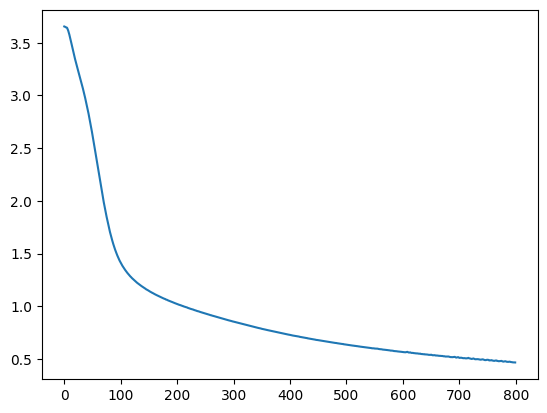

In [20]:
model_seq = nn.Sequential(
    nn.Linear(46, 400),
    nn.ReLU(),
    nn.Linear(400, 300),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(300, 200),
    nn.Dropout(0.10),
    nn.ReLU(),
    nn.Linear(200, 34)
).to(DEVICE)

epochs_hp = 800
MLPModel = NetWrapper(model_seq,DEVICE,epochs_hp,weights_mlp, True)

tmp = summary(MLPModel.model, (1, 46))
del tmp

losses = MLPModel.fit(xTrain_mlp, yTrain_mlp)

losses = [i.cpu().detach().numpy() for i in losses]
plt.plot(losses)
plt.show()

In [21]:
yTrain_hat_mlp34 = MLPModel.predict(xTrain_mlp)
yVal_hat_mlp34 = MLPModel.predict(xVal)

In [32]:
del undersample, xTrain_mlp, weights_mlp, MLPModel, model_seq

### Logistic Regression - 8 Classes

8 Classes (Attack Groups + Benign)

In [30]:
weights_lr8 = calcWeights(yTrain_8_int)

[0.973046425665774, 0.973046425665774, 0.5892449433021197, 0.8959193947139479, 0.9191392769973221, 0.8652321283288701, 0.9460928513315481, 0.8382785539946441]


In [35]:
# Defining the neural network architecture
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(in_features=46, out_features=8)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        logits = self.sigmoid(x)
        return logits

[Epoch   100 of 5000] loss: 2.076713
[Epoch   200 of 5000] loss: 2.013170
[Epoch   300 of 5000] loss: 1.951596
[Epoch   400 of 5000] loss: 1.900688
[Epoch   500 of 5000] loss: 1.860143
[Epoch   600 of 5000] loss: 1.827480
[Epoch   700 of 5000] loss: 1.800442
[Epoch   800 of 5000] loss: 1.777534
[Epoch   900 of 5000] loss: 1.757993
[Epoch  1000 of 5000] loss: 1.741094
[Epoch  1100 of 5000] loss: 1.726283
[Epoch  1200 of 5000] loss: 1.713027
[Epoch  1300 of 5000] loss: 1.700969
[Epoch  1400 of 5000] loss: 1.690093
[Epoch  1500 of 5000] loss: 1.679898
[Epoch  1600 of 5000] loss: 1.670497
[Epoch  1700 of 5000] loss: 1.661582
[Epoch  1800 of 5000] loss: 1.653279
[Epoch  1900 of 5000] loss: 1.645596
[Epoch  2000 of 5000] loss: 1.638258
[Epoch  2100 of 5000] loss: 1.631511
[Epoch  2200 of 5000] loss: 1.625359
[Epoch  2300 of 5000] loss: 1.619497
[Epoch  2400 of 5000] loss: 1.614066
[Epoch  2500 of 5000] loss: 1.608886
[Epoch  2600 of 5000] loss: 1.603866
[Epoch  2700 of 5000] loss: 1.599092
[

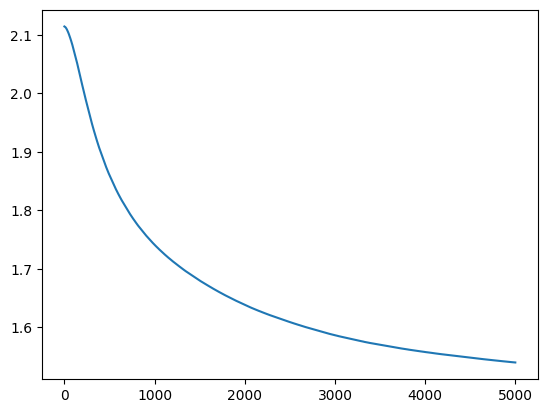

In [42]:
model_seq = LogisticRegression().to(DEVICE)
LRModel_8 = NetWrapper(model_seq,DEVICE,5000,weights_lr8)
losses = LRModel_8.fit(xTrain, yTrain_8_int)

losses = [i.cpu().detach().numpy() for i in losses]
plt.plot(losses)
plt.show()

In [43]:
yTrain_hat_lr8 = LRModel_8.predict(xTrain)
yVal_hat_lr8 = LRModel_8.predict(xVal)

yTrain_hat_lr8_str = np.array([attack_group_list[int(i)] for i in yTrain_hat_lr8])
yVal_hat_lr8_str = np.array([attack_group_list[int(i)] for i in yVal_hat_lr8])

del yTrain_hat_lr8, yVal_hat_lr8

In [ ]:
del weights_lr8, LRModel_8

### Logistic Regression - 2 Classes

2 Classes (Attack / Benign)

In [18]:
weights_lr2 = calcWeights(yTrain_2_int)

[0.02695357433422596, 0.973046425665774]


In [19]:
# Defining the neural network architecture
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(in_features=46, out_features=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        logits = self.sigmoid(x)
        return logits

[Epoch   100 of 2000] loss: 0.714993
[Epoch   200 of 2000] loss: 0.660991
[Epoch   300 of 2000] loss: 0.624339
[Epoch   400 of 2000] loss: 0.601575
[Epoch   500 of 2000] loss: 0.584270
[Epoch   600 of 2000] loss: 0.569985
[Epoch   700 of 2000] loss: 0.557585
[Epoch   800 of 2000] loss: 0.546891
[Epoch   900 of 2000] loss: 0.537689
[Epoch  1000 of 2000] loss: 0.529740
[Epoch  1100 of 2000] loss: 0.522792
[Epoch  1200 of 2000] loss: 0.516636
[Epoch  1300 of 2000] loss: 0.511105
[Epoch  1400 of 2000] loss: 0.506106
[Epoch  1500 of 2000] loss: 0.501530
[Epoch  1600 of 2000] loss: 0.497313
[Epoch  1700 of 2000] loss: 0.493413
[Epoch  1800 of 2000] loss: 0.489765
[Epoch  1900 of 2000] loss: 0.486311
[Epoch  2000 of 2000] loss: 0.483089


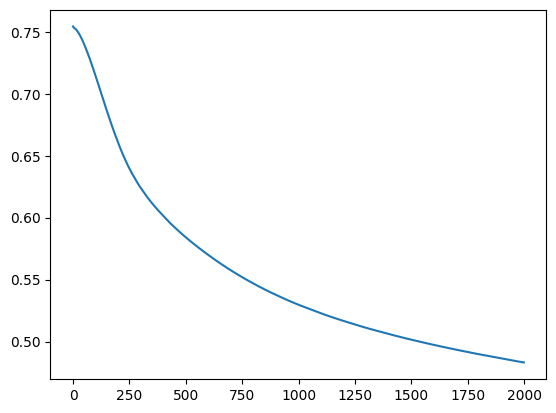

In [20]:
model_seq = LogisticRegression().to(DEVICE)
LRModel_2 = NetWrapper(model_seq,DEVICE,2000,weights_lr2)
losses = LRModel_2.fit(xTrain, yTrain_2_int)

losses = [i.cpu().detach().numpy() for i in losses]
plt.plot(losses)
plt.show()

In [21]:
yTrain_hat_lr2 = LRModel_2.predict(xTrain)
yVal_hat_lr2 = LRModel_2.predict(xVal)

yTrain_hat_lr2_str = np.array([attack_benign_list[int(i)] for i in yTrain_hat_lr2])
yVal_hat_lr2_str = np.array([attack_benign_list[int(i)] for i in yVal_hat_lr2])

del yTrain_hat_lr2, yVal_hat_lr2

In [ ]:
del weights_lr2, LRModel_2

### 3. Model Performance

Make sure to include the following:
- Performance on the training set
- Performance on the test set
- Provide some screenshots of your output (e.g., pictures, text output, or a histogram of predicted values in the case of tabular data). Any visualization of the predictions are welcome.

## Results

### Helper functions for summary

In [22]:
def summaryPerf(yTrain,yTrainHat,y,yHat,OH=False,yLabels=None):

    if OH:
        yTrain=np.argmax(yTrain,axis=1)
        y = np.argmax(y,axis=1)
    
    # Plotting confusion matrix for the non-training set:
    cm = metrics.confusion_matrix(y,yHat,normalize='true')
    cm = np.round(cm, decimals=1)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=yLabels)
    fig, ax = plt.subplots(figsize=(15,15))
    disp.plot(ax=ax, xticks_rotation='vertical')

    # Displaying metrics for training and non-training sets
    print('Training:  Acc = {:4.3f}'.format(metrics.accuracy_score(yTrain,yTrainHat)))
    print('Non-Train: Acc = {:4.3f}'.format(metrics.accuracy_score(y,yHat)))
    print('Training:  BalAcc = {:4.3f}'.format(metrics.balanced_accuracy_score(yTrain,yTrainHat,adjusted=True)))
    print('Non-Train: BalAcc = {:4.3f}'.format(metrics.balanced_accuracy_score(y,yHat)))

### Random Forest - 34 classes

In [25]:
__import__("warnings").filterwarnings('always')

Training:  Acc = 1.000
Non-Train: Acc = 0.992
Training:  BalAcc = 1.000
Non-Train: BalAcc = 0.776
recall_score:  0.7758185163343884


c:\Users\nithin\Desktop\my files\study\spr24\NN\final project\work\nn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


precision_score:  0.8259632942505779
f1_score:  0.7788870475695224


c:\Users\nithin\Desktop\my files\study\spr24\NN\final project\work\nn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nithin\Desktop\my files\study\spr24\NN\final project\work\nn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

       Backdoor_Malware       0.71      0.62      0.67         8
          BenignTraffic       0.91      0.93      0.92      2439
       BrowserHijacking       1.00      0.09      0.17        11
       CommandInjection       0.20      0.20      0.20         5
 DDoS-ACK_Fragmentation       0.99      0.99      0.99       635
        DDoS-HTTP_Flood       1.00      0.97      0.99        72
        DDoS-ICMP_Flood       1.00      1.00      1.00     15962
DDoS-ICMP_Fragmentation       0.98      1.00      0.99      1057
      DDoS-PSHACK_Flood       1.00      1.00      1.00      9335
       DDoS-RSTFINFlood       1.00      1.00      1.00      9041
         DDoS-SYN_Flood       1.00      1.00      1.00      9085
         DDoS-SlowLoris       0.78      0.96      0.86        52
DDoS-SynonymousIP_Flood       1.00      1.00      1.00      8090
         DDoS-TCP_Flood       1.00      1.00      1.00     10185
         DDoS-UDP_Flood 

c:\Users\nithin\Desktop\my files\study\spr24\NN\final project\work\nn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Predicted Attack,Backdoor_Malware,BenignTraffic,BrowserHijacking,CommandInjection,DDoS-ACK_Fragmentation,DDoS-HTTP_Flood,DDoS-ICMP_Flood,DDoS-ICMP_Fragmentation,DDoS-PSHACK_Flood,DDoS-RSTFINFlood,...,Mirai-greeth_flood,Mirai-greip_flood,Mirai-udpplain,Recon-HostDiscovery,Recon-OSScan,Recon-PingSweep,Recon-PortScan,SqlInjection,VulnerabilityScan,XSS
Actual Attack,,,,,,,,,,,,,,,,,,,,,
Backdoor_Malware,5,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
BenignTraffic,0,2271,0,2,0,0,0,0,0,0,...,0,0,0,19,27,1,30,0,0,0
BrowserHijacking,0,3,1,0,0,0,0,0,0,0,...,0,0,0,3,0,0,1,0,0,0
CommandInjection,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
DDoS-ACK_Fragmentation,0,0,0,0,629,0,0,3,0,0,...,0,2,0,0,0,0,0,0,0,0
DDoS-HTTP_Flood,0,0,0,0,0,70,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
DDoS-ICMP_Flood,0,0,0,0,0,0,15949,2,0,0,...,0,0,0,0,0,0,0,0,7,0
DDoS-ICMP_Fragmentation,0,0,0,0,0,0,0,1052,0,0,...,0,0,0,0,0,0,0,0,3,0
DDoS-PSHACK_Flood,0,0,0,0,0,0,0,2,9333,0,...,0,0,0,0,0,0,0,0,0,0


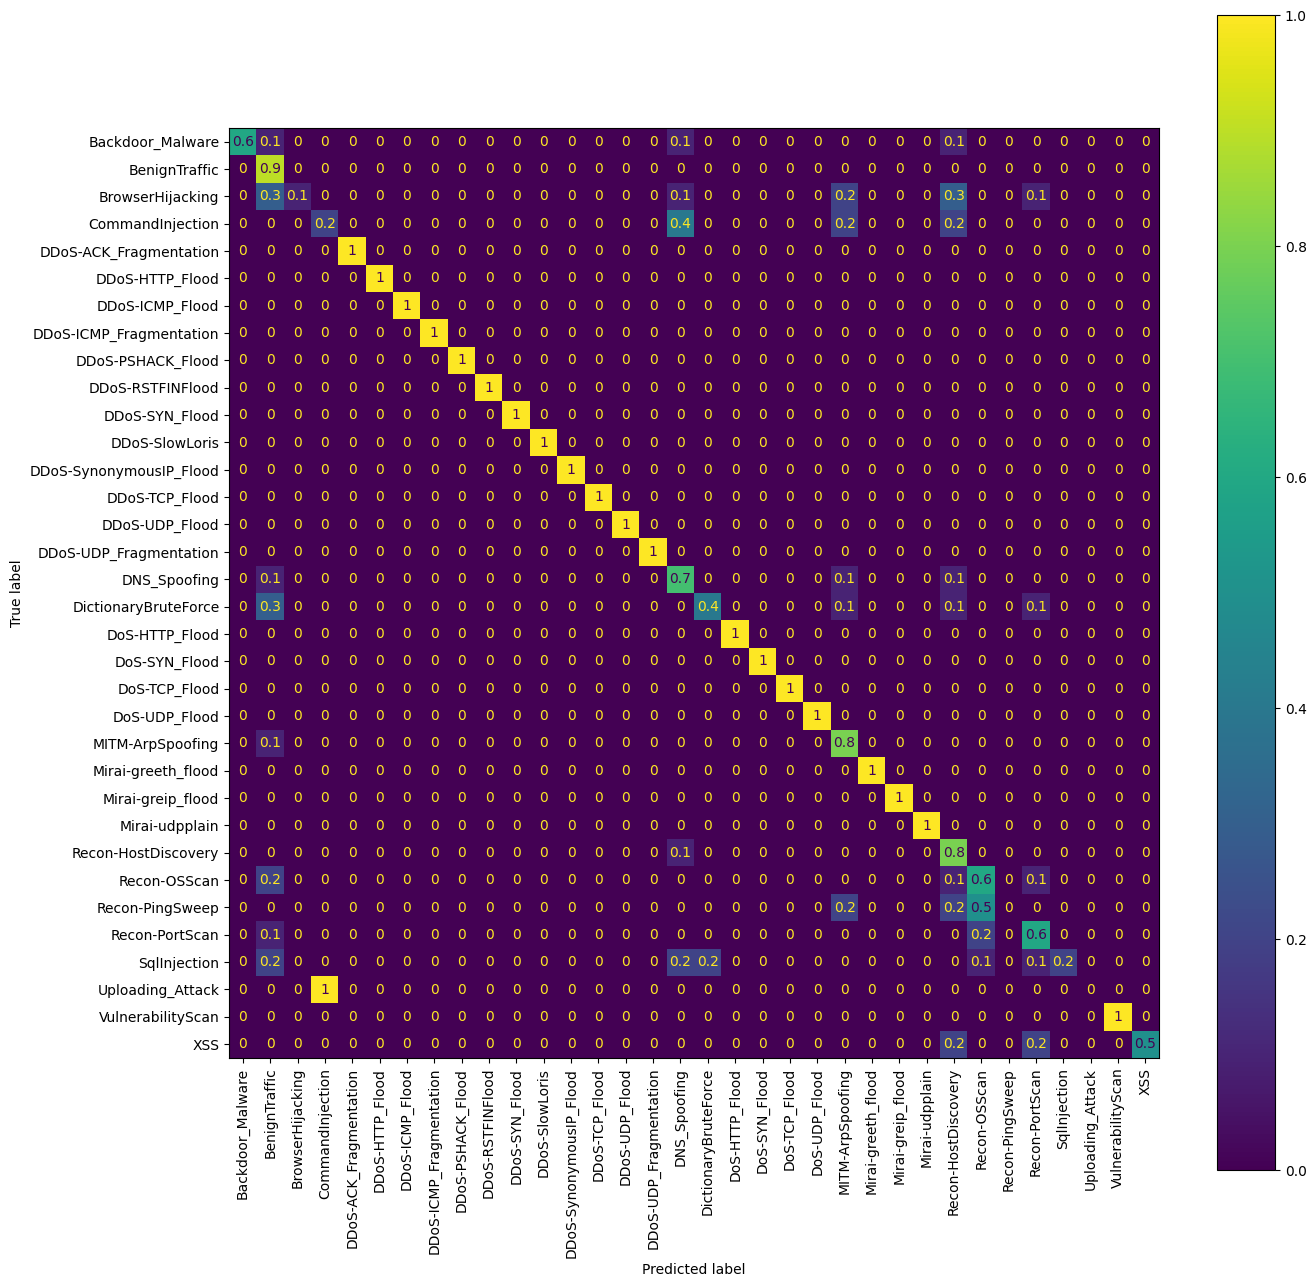

In [26]:
summaryPerf(yTrain, yTrain_hat_rf34_str, yVal, yVal_hat_rf34_str, yLabels=all_attacks_list)

print('recall_score: ', recall_score(yVal, yVal_hat_rf34_str, average='macro'))
print('precision_score: ', precision_score(yVal, yVal_hat_rf34_str, average='macro'))
print('f1_score: ', f1_score(yVal, yVal_hat_rf34_str, average='macro'))

print(classification_report(yVal, yVal_hat_rf34_str))
pd.crosstab(yVal, yVal_hat_rf34_str, rownames=['Actual Attack'], colnames=['Predicted Attack'])

### MLP - 34 classes

Training:  Acc = 0.846
Non-Train: Acc = 0.832
Training:  BalAcc = 0.841
Non-Train: BalAcc = 0.666


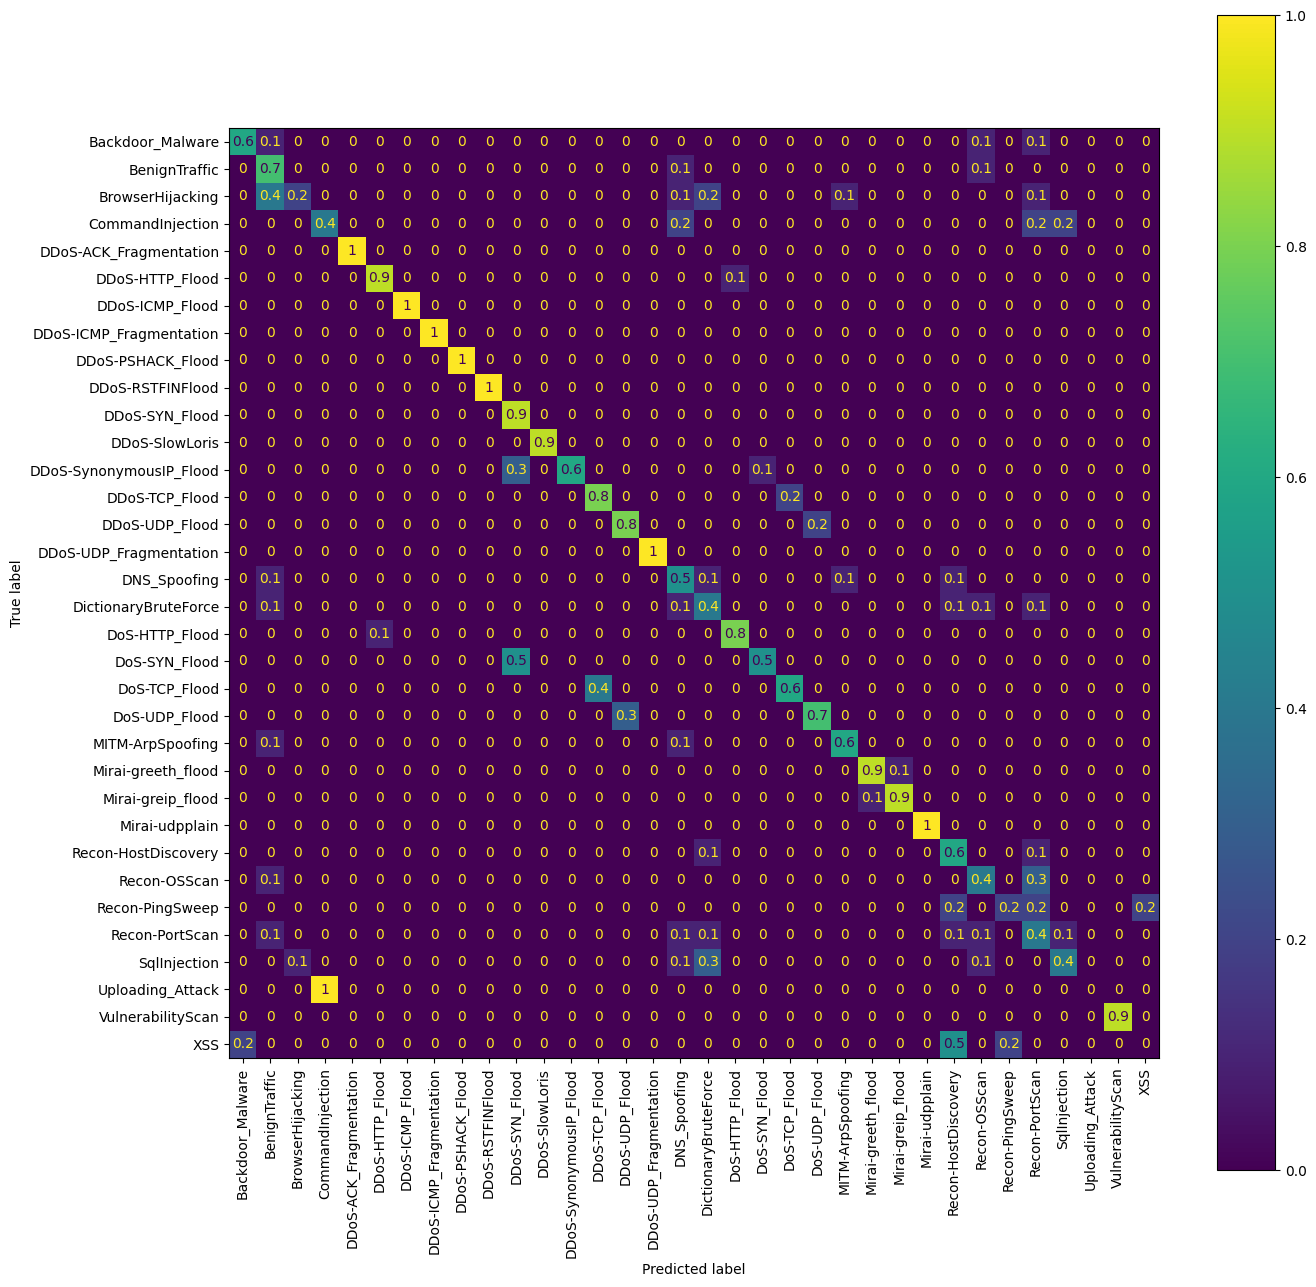

In [33]:
summaryPerf(yTrain_mlp,yTrain_hat_mlp34,yVal_34_OH,yVal_hat_mlp34,True, all_attacks_list)

### LR - 8 classes

Training:  Acc = 0.592
Non-Train: Acc = 0.582
Training:  BalAcc = 0.407
Non-Train: BalAcc = 0.490


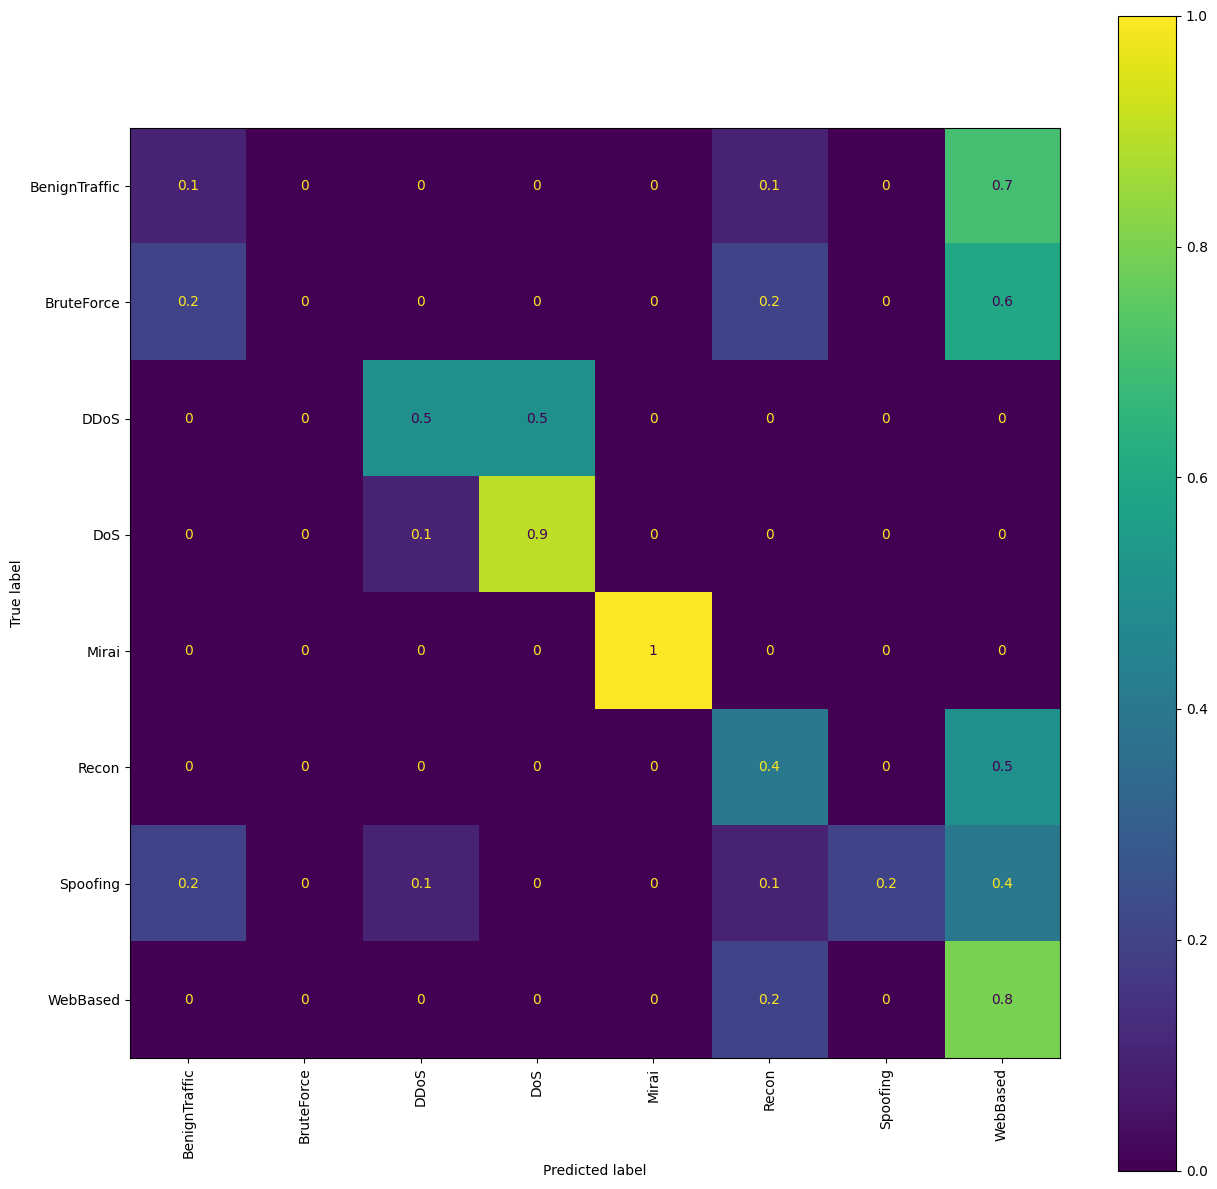

In [49]:
summaryPerf(yTrain_8,yTrain_hat_lr8_str,yVal_8,yVal_hat_lr8_str, False, attack_group_list)

### LR - 8 classes

Training:  Acc = 0.833
Non-Train: Acc = 0.973
Training:  BalAcc = 0.721
Non-Train: BalAcc = 0.928


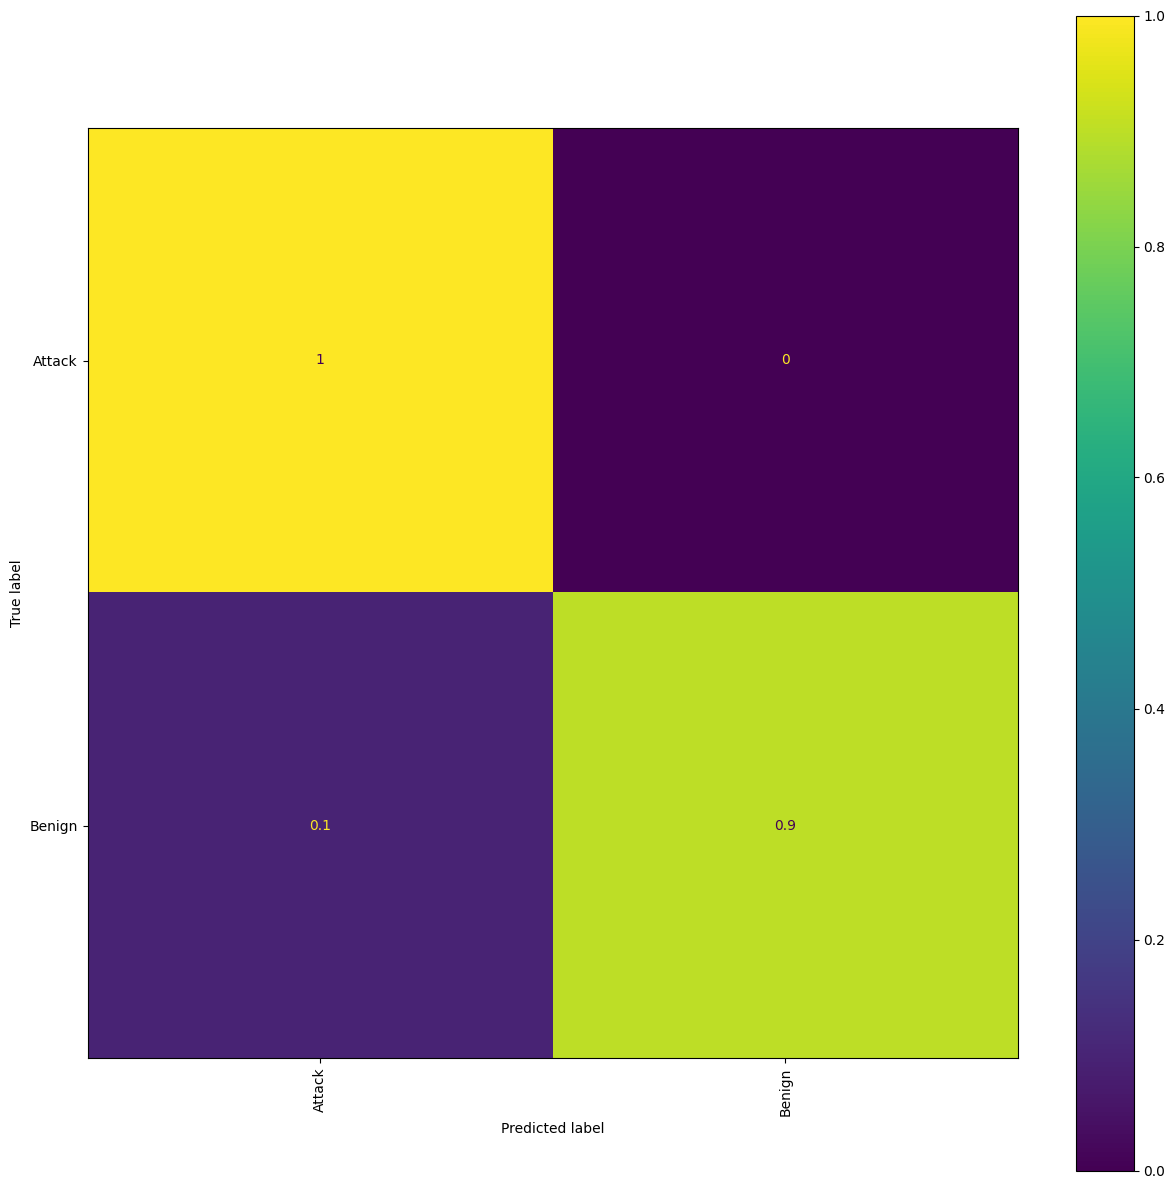

In [24]:
summaryPerf(yTrain_2,yTrain_hat_lr2_str,yVal_2,yVal_hat_lr2_str, False, attack_benign_list)